## Importing Packages

In [1]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
#from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## Loading Dataset

In [4]:
df = pd.read_csv('cleaned_dataset.csv')
df.head()

,Unnamed: 0,SoldPr,Type,Zip,Area,Rooms,FullBaths,HalfBaths,BsmtBth,Beds,BsmtBeds,GarageSpaces,houseEra
0,3500,294718.041797,SFH,60077,1100,7,1,0,No,3.0,0,2.0,19A
1,6859,330946.875000,SFH,60025,1600,6,2,0,No,3.0,0,2.0,19B
2,6623,415125.000000,SFH,60025,1500,7,2,0,Yes,3.0,0,2.0,19A
3,8672,336662.931641,SFH,60076,1422,9,1,1,No,3.0,0,2.5,19A
4,4572,571775.077344,SFH,60062,2668,8,2,1,No,4.0,0,2.0,19A


# Deleting First Column

In [5]:
df.drop("Unnamed: 0" , inplace = True , axis = 1)

In [7]:
df.dtypes

SoldPr          float64
Type             object
Zip               int64
Area              int64
Rooms             int64
FullBaths         int64
HalfBaths         int64
BsmtBth          object
Beds            float64
BsmtBeds          int64
GarageSpaces    float64
houseEra         object
dtype: object

In [9]:
df['Zip'] = df['Zip'].astype(str)
df.dtypes

SoldPr          float64
Type             object
Zip              object
Area              int64
Rooms             int64
FullBaths         int64
HalfBaths         int64
BsmtBth          object
Beds            float64
BsmtBeds          int64
GarageSpaces    float64
houseEra         object
dtype: object

# Checking The Dataset :

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9358 entries, 0 to 9357
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SoldPr        9358 non-null   float64
 1   Type          9358 non-null   object 
 2   Zip           9358 non-null   object 
 3   Area          9358 non-null   int64  
 4   Rooms         9358 non-null   int64  
 5   FullBaths     9358 non-null   int64  
 6   HalfBaths     9358 non-null   int64  
 7   BsmtBth       9358 non-null   object 
 8   Beds          9358 non-null   float64
 9   BsmtBeds      9358 non-null   int64  
 10  GarageSpaces  9358 non-null   float64
 11  houseEra      9358 non-null   object 
dtypes: float64(3), int64(5), object(4)
memory usage: 877.4+ KB


In [12]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')


5988 train examples
1498 validation examples
1872 test examples


Next, we will separate the training and validation dataframes into features and targets and do a rough normalisation of price.

In [13]:
housePrices_features = train.copy()
housePrices_labels = housePrices_features.pop('SoldPr')
housePrices_labels = housePrices_labels/100000

val_features = val.copy()
val_labels = val.pop('SoldPr')
val_labels = val_labels/100000

In [14]:
print(housePrices_features.dtypes)
print(housePrices_labels.dtypes)

Type             object
Zip              object
Area              int64
Rooms             int64
FullBaths         int64
HalfBaths         int64
BsmtBth          object
Beds            float64
BsmtBeds          int64
GarageSpaces    float64
houseEra         object
dtype: object
float64


In [15]:
inputs = {}

for name, column in housePrices_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'Type': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Type')>,
 'Zip': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Zip')>,
 'Area': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Area')>,
 'Rooms': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Rooms')>,
 'FullBaths': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'FullBaths')>,
 'HalfBaths': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'HalfBaths')>,
 'BsmtBth': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'BsmtBth')>,
 'Beds': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Beds')>,
 'BsmtBeds': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BsmtBeds')>,
 'GarageSpaces': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'GarageSpaces')>,
 'houseEra': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'houseEra')>}

In [17]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(df[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'normalization_1')>

Collect all the symbolic preprocessing results, to concatenate them later.

In [18]:
preprocessed_inputs = [all_numeric_inputs]

String fields will first use a StringLookup function to map the strings to their corresponding index in a vocabulary based on the different data strings. Second, using the index and default settings, the Tensorflow's pre-processing category encoding will generate a one-hot vector.

Together with the numeric field handling, we then transform the input data.

In [20]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = preprocessing.StringLookup(vocabulary=np.unique(housePrices_features[name]))
  one_hot = preprocessing.CategoryEncoding(num_tokens =lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

Given the preprocessed inputs (for normalisation and categorisation) and the corresponding input fields we can build a model the preprocesses the input data. We can visualise the model, as shown below.

In [22]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

housePrices_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = housePrices_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
housePrices_features_dict = {name: np.array(value)
                         for name, value in housePrices_features.items()}

In [24]:
features_dict = {name:values[:1] for name, values in housePrices_features_dict.items()}
housePrices_preprocessing(features_dict)

<tf.Tensor: shape=(1, 69), dtype=float32, numpy=
array([[-0.443, -0.399, -1.248,  0.767, -0.226, -0.374,  0.243,  0.   ,
         0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,
         1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  1.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  1.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ]], dtype=float32)>

In [25]:
def housePrices_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64,activation='relu'),
    #layers.Dense(64,activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

housePrices_model = housePrices_model(housePrices_preprocessing, inputs)

When you train the model, pass the dictionary of features as 'x', and the label as 'y'.

In [26]:
val_features_dict = {name: np.array(value)
                         for name, value in val.items()}
history_1 = housePrices_model.fit(x=housePrices_features_dict, y=housePrices_labels,epochs=250,
                        validation_data=(val_features_dict, val_labels))

Epoch 1/250
188/188 [==============================] - 3s 13ms/step - loss: 5.0737 - mae: 1.3223 - val_loss: 2.0653 - val_mae: 0.8644
Epoch 2/250
188/188 [==============================] - 2s 11ms/step - loss: 2.1224 - mae: 0.8547 - val_loss: 1.7354 - val_mae: 0.7682
Epoch 3/250
188/188 [==============================] - 2s 11ms/step - loss: 1.9978 - mae: 0.8361 - val_loss: 1.7121 - val_mae: 0.7688
Epoch 4/250
188/188 [==============================] - 2s 11ms/step - loss: 1.8955 - mae: 0.8102 - val_loss: 1.6625 - val_mae: 0.7603
Epoch 5/250
188/188 [==============================] - 2s 11ms/step - loss: 1.8635 - mae: 0.8073 - val_loss: 1.6242 - val_mae: 0.7424
Epoch 6/250
188/188 [==============================] - 2s 11ms/step - loss: 1.7945 - mae: 0.7850 - val_loss: 1.7151 - val_mae: 0.7665
Epoch 7/250
188/188 [==============================] - 2s 11ms/step - loss: 1.7828 - mae: 0.7932 - val_loss: 1.7042 - val_mae: 0.7638
Epoch 8/250
188/188 [==============================] - 2s 11ms

It is crucial to visualise the metrics produced during training; this will quickly indicate how quickly the model converges, potential issues of under and overfitting.

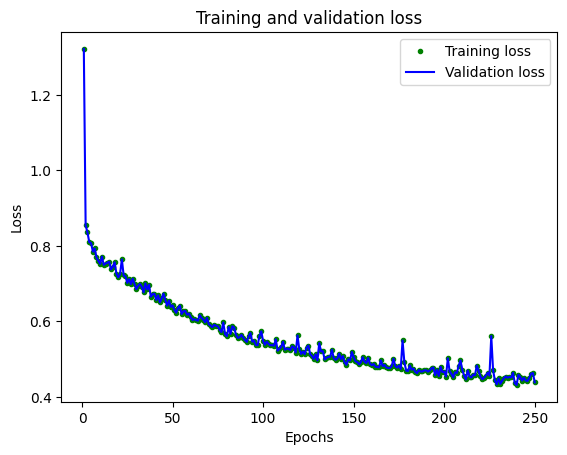

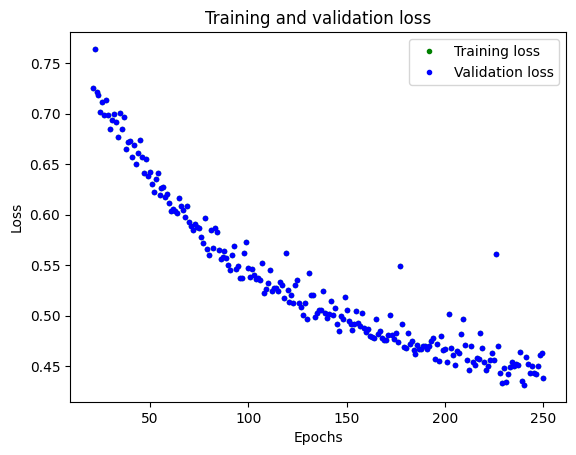

In [27]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
import matplotlib.pyplot as plt
train_loss = history_1.history['mae']
val_loss = history_1.history['mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 20

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

By implementing pre-processing as part of the model, we can now save the model and deploy it elsewhere as a simple package.

In [28]:
# Saving Model

In [29]:
housePrices_model.save('test.h5')

In [30]:
reloaded = tf.keras.models.load_model('test.h5')

In [ ]:
! zip -r test.zip test

In [31]:
features_dict = {name:values[:1] for name, values in housePrices_features_dict.items()}

before = housePrices_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

tf.Tensor([[2.092]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.092]], shape=(1, 1), dtype=float32)


Finally, we can run predictions on our own data.

In [32]:


houseData_own2 = {'Type': np.array(['SFH', 'SFH', 'SFH', 'Condo', 'Condo']),
  'houseEra': np.array(['recent', '19A', '20A', '20A', '19B']),
	'Area': np.array([8410, 1400, 1500, 1500, 1600]),
  'Zip': np.array(['60062', '60062', '60076', '60076', '60202']),
	'Rooms': np.array([16, 6, 7, 7, 7]),
  'FullBaths': np.array([6.0, 2.0, 2.0, 2.5, 2.0]),
  'HalfBaths': np.array([0.0, 1.0, 1.0, 0.0, 0.0]),
  'BsmtBth': np.array(['Yes', 'No', 'No', 'No', 'No']),
  'Beds': np.array([5, 3, 3, 3, 3]),
  'BsmtBeds': np.array([1.0, 0.0, 0.0, 0.0, 0.0]),
  'GarageSpaces': np.array([3, 2, 0, 0, 0])  }

ans = reloaded.predict(houseData_own2)

print(ans)



1/1 [==============================] - 0s 268ms/step
[[14.554]
 [ 3.946]
 [ 3.435]
 [ 3.391]
 [ 4.035]]
